<a href="https://colab.research.google.com/github/marisdarmawan/ANIMAL-SHELTERS/blob/main/Movie_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MOVIE RECOMMENDER SYSTEM**

Yang pertama dilakukan adalah menginstall library yang dibutuhkan untuk project ini. 
1. Kaggle untuk mendownload dataset film dan ratings
2. Surprise untuk membuat sistem collaborative recommendation

In [54]:
!pip install -q kaggle
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import files
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [56]:
#mengecek versi tensorflow untuk memastikan dan GPU enabled untuk mempercepat training
print('Versi tensorflow yang dipakai adalah: ', tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Menggunakan GPU untuk training: ', device_name)

Versi tensorflow yang dipakai adalah:  2.9.2
Menggunakan GPU untuk training:  /device:GPU:0


In [57]:
#upload file json kaggle yang berisi token
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arisdarmawan","key":"1365f1d8eb10c4f0bb85f5570960c824"}'}

In [58]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Selanjutnya adalah mendownload dataset dari kaggle, di sini saya mendownload movies dataset

In [59]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

100% 228M/228M [00:06<00:00, 36.1MB/s]
100% 228M/228M [00:06<00:00, 37.0MB/s]


In [60]:
! mkdir dataset
! unzip the-movies-dataset.zip -d dataset

Archive:  the-movies-dataset.zip
  inflating: dataset/credits.csv     
  inflating: dataset/keywords.csv    
  inflating: dataset/links.csv       
  inflating: dataset/links_small.csv  
  inflating: dataset/movies_metadata.csv  
  inflating: dataset/ratings.csv     
  inflating: dataset/ratings_small.csv  


Berdasarkan website [Kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset), dataset terdiri dari beberapa file yaitu:

1. movies_metadata.csv: Dataset yang terdiri dari 45.000 data dan terdiri dari informasi metadata dari film tersebut.

2. keywords.csv: Berisi kata kunci untuk plot film di dataset.

3. credits.csv: Berisi dari daftar artis dan kru film.

4. links.csv: Berisi TMDB and IMDB IDs dari semua film yang ada di dataset.

5. links_small.csv: Merupakan versi kecil dari file link.csv yang hanya berisi 9.000 data.

6. ratings_small.csv: Berisi 100,000 rating dari 700 users pada 9,000 film.

In [61]:
movies = pd.read_csv('/content/dataset/movies_metadata.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Datasetnya terdiri dari 45.466 baris dan 24 kolom. Kita hanya akan fokus ke beberapa kolom saja, yaitu :
1. Budget : berapa dana yang dihabiskan untuk membuat film
2. Genres 
3. Id
4. Overview : berisi sinopsis cerita film
5. Popularity : angka popularitas film, semakin tinggi semakin populer film tersebut
6. title : judul film
7. vote_average : nilai rating rata-rata film dari hasil seluruh voting users.
8. vote_count : jumlah users yang memberi rating di film tersebut.

In [63]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


**DATA PREPARATION**

Kolom genre masih menggunakan format JSON jadi untuk mengekstrak genre film, kita membutuhkan module literal_eval dari library ast

In [64]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Selanjutnya adalah mengisi null value di beberapa kolom

In [65]:
#mengisi null value di vote_average dengan nilai 0
movies['vote_average'] = movies['vote_average'].fillna(0)

In [66]:
#mengisi null value di vote_count nilai 0
movies['vote_count'] = movies['vote_count'].fillna(0)

In [67]:
#mengisi null value di kolom popularity dengan nilai 0
movies['popularity'] = movies['popularity'].fillna('0')

Kolom popularity masih dalam format object sehingga formatnya harus diubah ke tipe float, namun ada data yang isinya kalimat sehingga harus dibersihkan terlebih dahulu.

In [68]:
#membersihkan data popularitas yang tidak berisi angka atau nilai
movies['popularity'] = movies['popularity'].replace('Beware Of Frost Bites',0)

In [69]:
#mengganti tipe data kolom popularity dengan tipe float
movies['popularity'] = movies['popularity'].astype('float')

Selanjutnya adalah membersihkan kolom budget dan mengganti formatnya dari object ke integer

In [70]:
movies[movies['budget'].str.contains('.jpg')]['budget']

19730    /ff9qCepilowshEtG2GYWwzt2bs4.jpg
29503    /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
35587    /zaSf5OG7V8X8gqFvly88zDdRm46.jpg
Name: budget, dtype: object

In [71]:
#mengganti kolom budget yang isinya string ke angka
movies.loc[movies['budget'].str.contains('.jpg'), 'budget'] = '0'

In [72]:
#mengganti tipe kolom budget dari object ke angka
movies['budget'] = movies['budget'].astype('int')

In [73]:
#mengisi kolom overview yang null dengan string kosong
movies['overview'] = movies['overview'].fillna('')

In [74]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


**EXPLORATORY DATA ANALYSIS (EDA)**

Untuk lebih memahami data yang ada di dataset, maka dilakukan EDA terlebih dahulu. Yang pertama, kita akan melakukan bivariate analysis terhadap variable vote_average dan vote_count.

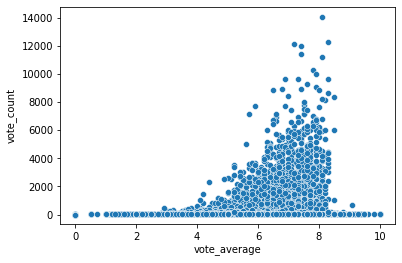

In [75]:
sns.scatterplot(data=movies,x='vote_average',y='vote_count')

Terlihat bahwa terdapat beberapa film yang ratingnya rendah sekali namun memiliki vote_count yang sedikit, sebaliknya ada beberapa film yang ratingnya tinggi yaitu > 9 dan jumlah vote nya juga sedikit. Mayoritas, film populer memiliki rating 7-8.

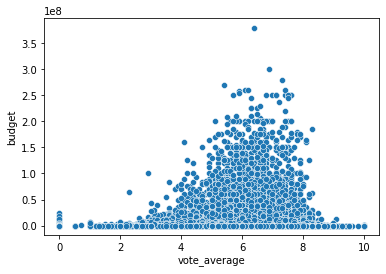

In [76]:
sns.scatterplot(data=movies,x='vote_average',y='budget')

Berdasarkan grafik di atas, terlihat bahwa film yang berbudget tinggi tidak mesti memiliki rating bagus, ada film yang budget rendah namun memiliki rating yang > 8

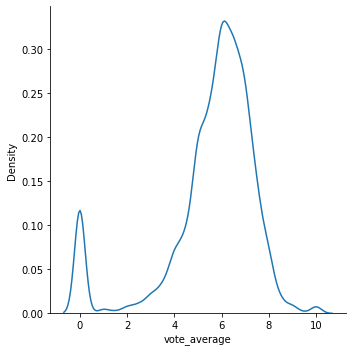

In [77]:
sns.displot(data=movies, x='vote_average',kind='kde')

Berdasarkan gambar di atas, terlihat bahwa jumlah rating film di dataset kebanyakan adalah 6 dan kurvanya hampir membentuk kurva distribusi normal.

In [118]:
movies = movies.sort_values('popularity',ascending=False)
movies[['original_title','popularity', 'vote_average']].head(5)

,original_title,popularity,vote_average
30700,Minions,547.488298,6.4
33356,Wonder Woman,294.337037,7.2
42222,Beauty and the Beast,287.253654,6.8
43644,Baby Driver,228.032744,7.2
24455,Big Hero 6,213.849907,7.8


Terlihat bahwa 3 dari 5 film populer merupakan film animasi (Minions, Beauty and the Beast, Big Hero 6). Ternyata, 5 film paling populer tidak memiliki rating di atas 8. Bahkan ada yang hanya 6 saja ratingnya.

In [79]:
movies[['original_title','popularity']].tail(5)

,original_title,popularity
41824,Ecaterina Teodoroiu,0.0
19730,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0
34210,Dahshat,0.0
41846,Vehshi Jatt,0.0
34319,Maalamaal,0.0


Film yang paling tidak populer merupakan film yang tentu saja tidak kita kenal, bahkan ada yang judulnya ngaco. Kemungkinan karena kesalahan input data.

In [80]:
movies = movies.sort_values('vote_average',ascending=False)
movies[['original_title','vote_average']].head(5)

,original_title,vote_average
43473,Ateş Böceği,10.0
27173,بید و باد,10.0
15383,Kaze no naka no kodomo,10.0
31251,The Mother Of Invention,10.0
18686,Säilöttyjä unelmia,10.0


Film yang punya rating sempurna ternyata bukan film yang terkenal ya

In [81]:
movies[['original_title','vote_average']].tail(5)

,original_title,vote_average
27433,Il tempo degli assassini,0.0
28454,Le malizie di Venere,0.0
33510,Mordi e fuggi,0.0
23214,Beauty and the Beast,0.0
34319,Maalamaal,0.0


Terlihat ada hal unik di dataset. Film Beauty and the Beast memiliki nilai rating 0 padahal merupakan film populer. Hal ini dikarenakan nilai rating di dataset tidak ada sehingga diberi 0. Kemungkinan karena error saat pengambilan dataset dari database.

**FEATURE ENGINEERING**

Yang pertama dilakukan adalah menghitung weighted rating terlebih dahulu. Berdasarkan [riset](https://rstudio-pubs-static.s3.amazonaws.com/626799_4ebaa715b4a84c188f8316e611ebf272.html), formula untuk menghitung weighted rating film adalah sebagai berikut:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

dimana,

* v adalah jumlah seluruh voting;
* m adalah jumlah minimum voting untuk dimasukkan ke dalam dataset;
* R adalah rata-rata voting dari film tersebut;
* C adalah rata-rata voting dari seluruh dataset;

In [82]:
C= movies['vote_average'].mean()
print(f"Nilai C adalah : {C}")

Nilai C adalah : 5.617465798618747


Untuk menentukan nilai m, digunakan metode quantile. Di projek ini, dipilih film yang hanya memiliki jumlah vote > 90% dari keseluruhan film di dataset.

In [83]:
m= movies['vote_count'].quantile(0.9)
print(f"Nilai m adalah : {m}")

Nilai m adalah : 160.0


Selanjutnya, kita filter film yang ada di dataset yang hanya film yang memiliki jumlah vote lebih dari 160.

In [84]:
movies_filtered = movies.loc[movies['vote_count'] >= m]
movies_filtered.shape

(4555, 24)

Setelah difilter dengan nilai m, kini hanya tersisa 4.555 film saja. Selanjutnya, menghitung nilai weighted_rating dari film.

In [85]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [86]:
movies_filtered['weighted_rating'] = movies_filtered.apply(weighted_rating, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
#mengurutkan film berdasarkan nilai weighted ratingnya
movies_filtered.sort_values('weighted_rating', ascending=False, inplace=True)

#Menampilkan top 10 film dengan weighted rating tertinggi
movies_filtered[['title', 'vote_count', 'vote_average', 'weighted_rating']].head(10).reset_index()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,index,title,vote_count,vote_average,weighted_rating
0,314,The Shawshank Redemption,8358.0,8.5,8.445855
1,834,The Godfather,6024.0,8.5,8.425420
2,10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421309
3,12481,The Dark Knight,12269.0,8.3,8.265467
4,2843,Fight Club,9678.0,8.3,8.256373
5,292,Pulp Fiction,8670.0,8.3,8.251392
6,522,Schindler's List,4436.0,8.3,8.206613
7,23673,Whiplash,4376.0,8.3,8.205378
8,5481,Spirited Away,3968.0,8.3,8.196026
9,2211,Life Is Beautiful,3643.0,8.3,8.187140


Ternyata, dengan adanya weighted_rating, 10 film dengan rating teratas merupakan film yang sudah banyak kita kenal dan memang merupakan film yang bagus dan menang beberapa penghargaan.

**CONTENT BASED RECOMMENDATION**

Di proyek ini hanya akan menggunakan dataset movies_filtered untuk memberikan sistem rekomendasi yang berasal dari film yang bagus saja, hal ini juga untuk menghemat penggunaan memory di google colab karena jika menggunakan dataset movies yang tidak difilter, runtime di google colab akan crash karena memory penuh. Content based recommendation yang akan dibentuk di proyek ini menggunakan feature overview yang berisi sinopsis dari cerita film sehingga sistem akan merekomendasikan film yang mirip jalan ceritanya.

In [89]:
movies_filtered['overview'].head()

314      Framed in the 1940s for the double murder of h...
834      Spanning the years 1945 to 1955, a chronicle o...
10309    Raj is a rich, carefree, happy-go-lucky second...
12481    Batman raises the stakes in his war on crime. ...
2843     A ticking-time-bomb insomniac and a slippery s...
Name: overview, dtype: object

Untuk mengubah sinopsis ke bentuk angka yang dapat digunakan oleh sistem rekomendasi, digunakan library TF-IDF.

In [90]:
tfidf = TfidfVectorizer(analyzer='word', stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_filtered['overview'])
tfidf_matrix.shape

(4555, 19694)

**Cosine Similarity**

Untuk mencari rekomendasi dari sinopsis atau cerita film yang mirip, digunakan metode cosine similarity dengan formula sebagai berikut :

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Karena kita menggunakan TF-IDF Vectorizer, untuk mendapatkan nilai cosine similarity tinggal mengkalikan dot product matriksnya saja. Di sini saya menggunakan modul **linear_kernel** karena lebih efisien dan cepat.

In [91]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [92]:
#Mencari indeks film di dataset
movies_filtered = movies_filtered.reset_index() #mereset index agar indexnya urut kembali
indices = pd.Series(movies_filtered.index, index=movies_filtered['title']).drop_duplicates()

In [93]:
#mendefinisikan fungsi rekomendasi untuk mencari rekomendasi film
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]     # mendapatkan 10 rekomendasi film yang paling mirip
    movie_indices = [i[0] for i in sim_scores]
    return movies_filtered['title'].iloc[movie_indices]

In [94]:
#menguji sistem rekomendasi sesuai judul film yang dicari
get_recommendations('The Godfather')

10       The Godfather: Part II
3405                 Blood Ties
670     The Godfather: Part III
2833              Live by Night
1140                   Sinister
4436      The Cold Light of Day
2310                        Joe
503           Road to Perdition
1370         Death at a Funeral
1529          The Addams Family
Name: title, dtype: object

Menggunakan prinsip yang sederhana, memberikan rekomendasi film berdasarkan cerita film yang sesuai sistem ini sudah memberikan hasil yang bagus. Para penyuka film Godfather kemungkinan akan suka dengan rekomendasi yang diberikan.

**COLLABORATIVE RECOMMENDATION**

Salah satu kekurangan sistem content based recommendation yang barusan dibuat adalah sistem akan merekomendasikan film yang memiliki jalan cerita sama sesuai film yang dipilih oleh user. Untuk membuat sistem rekomendasi yang lebih personal antar user, digunakan sistem rekomendasi kolaoratif. Sistem rekomendasi kolaboratif yang digunakan pada proyek ini menggunakan teknik Singular Value Decomposition (SVD) dari library surprise, formula dari SVD berdasarkan [MIT](https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm):

$An.p = Un.n Sn.p V^Tp.p $

dimana, 
* A = matriks rating film
* U = matriks user (faktor laten user)
* S = matriks diagonal (kekuatan antar faktor laten)
* V = matriks film (faktor laten film)

Dengan algoritma SVD, sistem rekomendasi akan memprediksi berapa rating yang diberikan oleh user berdasarkan data dari user lain yang telah memberikan rating ke film tersebut.

In [95]:
reader = Reader()

Dataset yang digunakan adalah dataset yang berisi rating yang diberikan user terhadap film

In [96]:
ratings = pd.read_csv('/content/dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Selanjutnya adalah menggunakan teknik SVD untuk memprediksi rating user dari film yang akan diberikan berdasarkan rating dari user lain.

In [97]:
svd = SVD()

Untuk menentukan performa dari algoritma SVD, digunakan matriks penilaian RMSE dan MAE dan cross_validasi sebanyak 5 kali.

In [98]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
output = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)

In [99]:
output

{'test_rmse': array([0.89748834, 0.89495856, 0.90053686, 0.90119478, 0.89396269]),
 'test_mae': array([0.69240608, 0.68945773, 0.69361148, 0.69324876, 0.68828157]),
 'fit_time': (6.335726737976074,
  4.269137859344482,
  4.2884862422943115,
  4.346724271774292,
  4.874194383621216),
 'test_time': (0.44597315788269043,
  0.1293625831604004,
  0.13523292541503906,
  0.26230692863464355,
  0.13997292518615723)}

In [100]:
rmse = round(output['test_rmse'].mean(),3)
mae = round(output['test_mae'].mean(),3)
print(f"Nilai RMSE dari model SVD adalah : {rmse}")
print(f"Nilai MAE dari model SVD adalah : {mae}")

Nilai RMSE dari model SVD adalah : 0.898
Nilai MAE dari model SVD adalah : 0.691


Berdasarkan hasil validasi, nilai RMSE dan MAE termasuk bagus karena di bawah 1. Artinya jika user memberikan rating 4, maka prediksi model berada di rentang 3,2 hingga 4,8. Selanjutnya kita akan memasukkan data tsb ke model SVD untuk dilakukan training.

In [101]:
train = data.build_full_trainset()
svd.fit(train)

Setelah dilakukan training, kita akan melihat prediksi model untuk user dengan id=2 dan film dengan id=10. Sesuai tabel di bawah, user tersebut memberikan rating 4.

In [102]:
ratings[ratings['userId'] == 2]

,userId,movieId,rating,timestamp
20,2,10,4.0,835355493
21,2,17,5.0,835355681
22,2,39,5.0,835355604
23,2,47,4.0,835355552
24,2,50,4.0,835355586
...,...,...,...,...
91,2,592,5.0,835355395
92,2,593,3.0,835355511
93,2,616,3.0,835355932
94,2,661,4.0,835356141


In [103]:
svd.predict(2, 10, 4, verbose=True)

user: 2          item: 10         r_ui = 4.00   est = 3.61   {'was_impossible': False}


Prediction(uid=2, iid=10, r_ui=4, est=3.6050162673897144, details={'was_impossible': False})

Berdasarkan hasil prediksi model SVD, rating yang diberikan user adalah 3,61 dengan rating sesungguhnya adalah 4. Performa ini dirasa cukup untuk dijadikan sistem rekomendasi. Selanjutnya, kita akan memperbaiki sistem rekomendasi sebelumnya dengan menambahkan algoritma SGD. Untuk membuat sistem rekomendasi, kita membutuhkan dataset yang berisi id untuk film.

In [104]:
links = pd.read_csv('/content/dataset/links_small.csv')

In [105]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [106]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


Terlihat bahwa kolom tmdbId ada yang berisi null value sehingga saya mengisi nilainya dengan 0, lalu kolom yang digunakan untuk sistem rekomendasi hanya kolom movieId dan tmdbId saja, untuk kolom imdbId tidak perlu karena sudah memilih kolom tmdbId (bisa pilih salah 1). Selanjutnya, mengubah kolom tmdbId ke bentuk integer untuk bisa dimerge nantinya dengan dataset movies_filtered.

In [107]:
links['tmdbId'] = links['tmdbId'].fillna(0)
id_map = links[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].astype('int')
id_map.columns = ['movieId', 'id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Selanjutnya, saya akan menggabungkan dataset movies_filtered dengan dataset id_map. Sebelumnya kolom id di movies_filtered harus diubah terlebih dahulu tipe datanya ke integer.

In [108]:
movies_filtered['id'] = movies_filtered['id'].astype('int')
id_map = id_map.merge(movies_filtered[['title', 'id']], on='id')

In [109]:
id_map.head()

,movieId,id,title
0,1,862,Toy Story
1,2,8844,Jumanji
2,5,11862,Father of the Bride Part II
3,6,949,Heat
4,9,9091,Sudden Death


Selanjutnya, pilih kolom title sebagai index.

In [110]:
id_map = id_map.set_index('title')
id_map.head()

,movieId,id
title,,
Toy Story,1,862
Jumanji,2,8844
Father of the Bride Part II,5,11862
Heat,6,949
Sudden Death,9,9091


Lalu, buat dataframe baru dengan memilih kolom id sebagai index.

In [111]:
indices_map = id_map.set_index('id')

In [112]:
indices_map.head()

,movieId
id,
862,1
8844,2
11862,5
949,6
9091,9


Lalu, buat fungsi baru yang akan memberikan rekomendasi berdasarkan userid dan judul film. Sistem rekomendasi ini akan memberikan rekomendasi film berdasarkan dengan jalan cerita film yang mirip dan prediksi rating dari algoritma SVD. Lalu sistem akan memberikan 10 film yang kemungkinan akan disukai oleh user sesuai prediksi rating tertinggi.

In [113]:
def improved_recommendation(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11] #memberikan 10 rekomendasi film yang paling mirip
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_filtered.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['predicted_rating'] = movies['id'].apply(lambda x: round(svd.predict(userId, indices_map.loc[x]['movieId']).est,1)) #memberikan nilai prediksi rating
    movies = movies.sort_values('predicted_rating', ascending=False) #mengurutkan film dengan rating prediksi tertinggi
    return movies

Sekarang kita akan mengetest hasil rekomendasi dari sistem ini. Kita akan memberikan rekomendasi film ke user 564 dan film yang telah ditontonnya adalah Jumanji.

In [114]:
improved_recommendation(564, "Jumanji")

,title,vote_count,vote_average,id,predicted_rating
358,Casino Royale,3930.0,7.3,36557,4.3
1776,eXistenZ,487.0,6.7,1946,4.1
3897,Gamer,778.0,5.6,18501,3.9
2414,Grandma's Boy,222.0,6.6,9900,3.8
3924,Pixels,2564.0,5.6,257344,3.6
548,Wreck-It Ralph,4656.0,7.1,82690,3.6
1801,Manhunter,340.0,6.8,11454,3.5
2571,The Last Starfighter,225.0,6.5,11884,3.4
1615,Panic Room,1303.0,6.6,4547,3.4
541,Geri's Game,309.0,7.8,13929,3.2


Lalu kita akan mengecek hasil rekomendasi untuk user lain dengan id 252 dengan film yang sama yaitu Jumanji.

In [115]:
improved_recommendation(252, "Jumanji")

,title,vote_count,vote_average,id,predicted_rating
358,Casino Royale,3930.0,7.3,36557,4.1
1801,Manhunter,340.0,6.8,11454,4.0
548,Wreck-It Ralph,4656.0,7.1,82690,3.9
2571,The Last Starfighter,225.0,6.5,11884,3.9
2414,Grandma's Boy,222.0,6.6,9900,3.8
3897,Gamer,778.0,5.6,18501,3.7
541,Geri's Game,309.0,7.8,13929,3.7
1615,Panic Room,1303.0,6.6,4547,3.6
3924,Pixels,2564.0,5.6,257344,3.5
1776,eXistenZ,487.0,6.7,1946,3.4


Berdasarkan hasil rekomendasi sistem, terlihat film yang direkomendasikan untuk kedua user urutannya berbeda meskipun keduanya sudah nonton film Jumanji. Perbedaan hasil rekomendasi diakibatkan dengan penambahan algoritma SVD yang memprediksi rating film untuk user tersebut.